# Analyzing Branded Food in the United States
### Spring 2024 Data Science Project
**Vicky Mai and Andrew Kim**
<br><br>
<img src='https://dealdesign.com/wp-content/uploads/2021/07/food-logos.png'/><br>
*Image from Deal Design: https://dealdesign.com/2021/08/03/food-logos-to-inspire-your-branding/*
<br><br>


Vicky Mai, Contribution: 100%<br>
Andrew Kim, Contribution: 100%

We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial.

Vicky Mai 5/7/2024<br>
Andrew Kim 5/7/2024

### Table of Contents

- 0. [Introduction](#0)

- 1. [Data Curation](#1)
        - [Imports](#11)
        - [Source of Data](#12)
        - [Data Preprocessing: Cleaning, Reduction, and Transformation](#13)

- 2. [Exploratory Data Analysis](#2)
        - [Distribution of Food Categories](#21)
        - [Distribution of Ingredients Per Category](#22)
        - [Simple Hypothesis Testing for Ingredient/Category Correlation](#23)

- 3. [Primary Analysis](#3)
        - [Explanation of Our Method Based on Exploratory Data Analysis](#31)
        - [Full Implementation Explanation](#32)
        - [Completed Model with Accuracy Report](#33)

- 4. [Visualization](#4)

- 5. [Insights and Conclusions](#5)

## 0. Introduction <a class="anchor" id="0"></a>

This is a tutorial using a real world example that walks through the entire data science pipeline: curating data, exploratory analysis of the data using various statistical methods, creating a machine learning model based on that analysis to answer questions, and visualizing results. We hope that our demonstation helps users understand this process better.

Our topic is on branded foods in the United States. We specifically want to focus on things like which categories of food have the most variety in branded items as well as the extent ingredients vary within each category of food. We can answer these in addition to multiple other minor questions we have as we perform exploratory data analysis leading up to our primary analysis.

However our main question for our primary analysis is:

**Using a machine learning (ML) model, can we accurately predict the category of a branded food item solely with its ingredients?**

We think that this is a valuable question to answer as if it is possible and we successfully create a model, then we can possibly make conclusions about various things like: 

Should this "healthy granola bar" really be considered a granola bar or is it more closely related to candy? 

Which brands have the most soup-like soups?

Of course we can also be able to help sort foods with unknown categories just knowing their ingredient labels. 

## 1. Data Curation <a class="anchor" id="1"></a>



In this section, we will organize our database of interest into pandas dataframes that will allows us to store, process, and analyze data. We will make necessary transformations to clean up the data for analysis.


#### Imports <a class="anchor" id="11"></a>
The following covers all the Python libraries we will use throughout this tutorial.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import chi2_contingency

# ignore warnings on all outputs in this tutorial
import warnings
warnings.filterwarnings('ignore')

#### Source of Data <a class="anchor" id="12"></a>
We will analyze data from the branded foods dataset provided by the U.S. Department of Agriculture's Agricultural Research Service: https://fdc.nal.usda.gov/download-datasets.html. Due to the sheer size of this download, we decided to only look at the *branded_food* and *food* tables/CSV files which should be suitable for the scope of analysis we are going for.

Field descriptions for these tables can be found at https://fdc.nal.usda.gov/portal-data/external/dataDictionary (page 3).

#### Data Preprocessing: Cleaning, Reduction, and Transformation <a class="anchor" id="13"></a>
Let's first load in and take a look at our main file, branded_food.csv:

In [4]:
brand_df = pd.read_csv("branded_food.csv")
print('Number of Rows: ', len(brand_df))
print('Number of Columns: ', len(brand_df.columns))
print('First Five Entries\n', brand_df.head(5))

Number of Rows:  1947155
Number of Columns:  20
First Five Entries
     fdc_id                               brand_owner brand_name subbrand_name  \
0  1105904  Richardson Oilseed Products (US) Limited        NaN           NaN   
1  1105905                     CAMPBELL SOUP COMPANY        NaN           NaN   
2  1105906                     CAMPBELL SOUP COMPANY        NaN           NaN   
3  1105907                     CAMPBELL SOUP COMPANY        NaN           NaN   
4  1105908                     CAMPBELL SOUP COMPANY        NaN           NaN   

      gtin_upc                                        ingredients  \
0  27000612323                                      Vegetable Oil   
1  51000198808  INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...   
2  51000213273  INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...   
3  51000213303  INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...   
4  51000224637  INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...   

  not_a_significant_source_of 

Wow! Our dataset is extremely large and complex, with 1947155 entries and 20 columns of information. In order to make it more simple for us to work with (as well as lower processing time), we can clean it up to only include information relevant for our interests as stated in the [Introduction](#0). 

We see that there are multiple columns of which the first 5 rows have no information: not_a_significant_source_of, household_serving_fulltext, package_weight, discontinued_date, preparation_state_code, trade_channel, and short_description. Columns with unavailable information can often interfere with analysis. In order to get an idea of possible missing/unknown values in the dataset, we can look up exactly how many rows each of our 20 attributes has data on.

In [5]:
brand_df.count()

fdc_id                         1947155
brand_owner                    1930265
brand_name                     1399308
subbrand_name                   101803
gtin_upc                       1947155
ingredients                    1941762
not_a_significant_source_of      78611
serving_size                   1936375
serving_size_unit              1928127
household_serving_fulltext      860681
branded_food_category          1936547
data_source                    1947155
package_weight                  803946
modified_date                  1947135
available_date                 1947155
market_country                 1947155
discontinued_date                    0
preparation_state_code           49703
trade_channel                    21184
short_description                49818
dtype: int64

Over 90% of rows have missing values for not_a_significant_source_of, discontinued_date, preparation_state_code, trade_channel, and short_description. Thus, there is no easy way to find or infer those missing those columns, so relative to the other information the dataset can tell us these attributes are pretty lacking. 

And since we are not interested in this info anyway, we can simply drop these columns.

Although subbrand_name is also uncommon, we decided to keep it to distinguish items that fall under the same brand, but different subbrands, e.g. "Lindt LINDOR" and "Lindt EXCELLENCE".

In [6]:
brand_df = brand_df.drop(["not_a_significant_source_of", "discontinued_date", "preparation_state_code", "trade_channel", "short_description"], axis=1)
brand_df.head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,27000612323,Vegetable Oil,15.0,ml,NaN,Oils Edible,GDSN,NaN,2020-10-02,2020-11-13,United States
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,51000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-09-12,2020-11-13,United States
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,51000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,51000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,51000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-10-03,2020-11-13,United States


We also noticed that we have 1947155 foods by fdc_id, but only 1930265 brand_owner attributes. In order to ensure all foods can be categorized by at least a brand owner when we make our conclusions, since branded foods are our focus, let's drop all those with unknown owners.
> Note: Sometimes it is possible to estimate a value to replace a missing attribute with based on rows with similar known attributes. This is great to do with numerical data types. However, in this case we cannot make inferences. Brand owner names must be completely accurate because products are either owned by a company or not - there is no "close enough."

In [7]:
brand_df = brand_df.dropna(subset=['brand_owner'])

Next, out of the remaining columns we looked for ones that are just not relevant for our current interests and therefore could set aside for simplicity. We figured that we can drop every column that isn't brand owner/name information except for, **ingredients**, **branded_food_category**, and **market_country**. Remember: per our [Introduction](#0), the main question we want to answer is given only **ingredients**, to what extent can we predict what **type of food** a **U.S.** branded product is?

Thus we are dropping:
- gtin_upc, the bar code that you scan in the grocery store
- data_source, source the data for the product came from
- modified_date, date when the product's data was last modified by the manufacturer
- available_date, date for when the product's data became available
- serving_size, gram/ml serving size
- serving_size_unit, gram/ml
- household_serving_fulltext, serving size and household unit e.g. 3 tbsp
- package_weight
> Note: It was definitely better to do this first before the first column drops, however as this is a tutorial we decided to keep that redundancy to share a bit more insight into the data cleaning process.

In [8]:
brand_df = brand_df.drop(['gtin_upc', 'data_source', 'modified_date', 'available_date', 'serving_size', 'serving_size_unit',
                          'household_serving_fulltext', 'package_weight'], axis=1)
brand_df.head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,ingredients,branded_food_category,market_country
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,Vegetable Oil,Oils Edible,United States
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",Herbs/Spices/Extracts,United States
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",Prepared Soups,United States
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",Prepared Soups,United States
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",Herbs/Spices/Extracts,United States


Now of course since we need to know product ingredients to do our primary analysis, let's drop all foods with unknown ingredients.

> Note: It may seem like we should drop those with unknown categories as well. We do do this during analysis. However, we thought it would be worthwhile to keep these in our main dataset to form insights at the end! What if we can fill in these unknowns using our predictive model?
<a id="note"></a>

In [9]:
brand_df = brand_df.dropna(subset=['ingredients'])

Finally, of course since we are analyzing branded foods in the United States we only want foods where the U.S. is the primary country the food is marketed in. So we have to check the market_country column.

In [10]:
brand_df['market_country'].value_counts()

United States    1923757
New Zealand         1117
Name: market_country, dtype: int64

As expected from a USDA dataset an overwhelming majority of the products (99.94%) do have the U.S as its market country.
Let's leave out the tiny portion of New Zealand ones, and afterwards since we know our DataFrame will solely have U.S. branded foods information we can just drop the market_country column.

In [11]:
brand_df = brand_df[brand_df['market_country'] == 'United States']
brand_df = brand_df.drop(['market_country'], axis=1)
brand_df.head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,ingredients,branded_food_category
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,Vegetable Oil,Oils Edible
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",Herbs/Spices/Extracts
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",Prepared Soups
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",Prepared Soups
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",Herbs/Spices/Extracts


Next we want to load in food_csv:
> Note: This table contains the specific food descriptors (i.e. with fdc_ids 1234 and 1235, "FakeBrand's Souptastic Clam Chowder" and "FakeBrand's Souptastic Chicken Soup" descriptors come from the same brand: brand_owner "FakeBrand", brand_name "Souptastic" in branded_foods). Of course it can be more general like "Bagels" for a brand of bagels.


In [12]:
food_df = pd.read_csv("food.csv")
food_df.head(5)

,fdc_id,data_type,description,food_category_id,publication_date,market_country,trade_channel,microbe_data
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."
4,1105908,branded_food,SWANSON BROTH CHICKEN,NaN,2020-11-13,United States,NaN,"[{""min_value"":null,""uom"":null,""microbe_method""..."


We only are interested in food names from the description column. Thus to make it easier on us, let's update our main DataFrame brand_df by attributing item descriptors to brands:

In [13]:
brand_df.insert(4, "name", food_df[food_df['fdc_id'].isin(brand_df['fdc_id'])]['description'])
brand_df.head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,name,ingredients,branded_food_category
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,WESSON Vegetable Oil 1 GAL,Vegetable Oil,Oils Edible
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,SWANSON BROTH BEEF,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",Herbs/Spices/Extracts
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",Prepared Soups
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",Prepared Soups
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,SWANSON BROTH CHICKEN,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",Herbs/Spices/Extracts


In [14]:
brand_df.count()

fdc_id                   1923757
brand_owner              1923757
brand_name               1380295
subbrand_name             101412
name                     1923757
ingredients              1923757
branded_food_category    1913958
dtype: int64

We now have an easy to understand DataFrame of size 1923757, reduced to information relevant to our goals and cleaned based on basic information. Now we can dive in deeper!
> Note: We may need to do more involved cleaning operations based on initial analysis findings in order to do our primary analysis. Finding less obvious factors to consider before building and training a machine learning model✨ is the main purpose of our next section!

## 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

In this section, we will do some initial analysis in order to better understand how our data is laid out as well as how plausible our primary analysis idea, building a ML model for ingredients to food type categorization, is to implement. Do ingredients actually have an effect on branded food categories? What kind of model should we use? Are there outliers, an imbalance, or a weird distribution to consider, and if so how can we clean up our training data around those issues?

We explored the data from three angles using various statistical methods.

### 2.1. Distribution of Food Categories <a class="anchor" id="21"></a>

We want to get an idea of how our products are currently categorized in our dataset. How is the branded foods dataset distributed across food categories? Which categories have the most variety of branded items? The least? We can visualize this with some plots as well. 

Let's first make a new DataFrame that drops uncategorized food items from our main brand_df [(note)](#note).

In [15]:
known_cats = brand_df.dropna(subset=['branded_food_category'], how='all')

In [16]:
print('Number of Food Categories: ', len(known_cats['branded_food_category'].unique()))

Number of Food Categories:  331


331 is a lot! Now let's peek into the product counts within them.

In [17]:
print('Categories with the Lowest Variation in Branded Foods\n', 
      known_cats['branded_food_category'].value_counts().sort_values().head(10))

print('\nCategories with the Highest Variation in Branded Foods\n', 
      known_cats['branded_food_category'].value_counts().sort_values(ascending=False).head(10))

print('\nCategory with the Highest Variation in Branded Foods Percent of Dataset: ' +
      f"{known_cats['branded_food_category'].value_counts().sort_values(ascending=False).head(1)[0]/known_cats['fdc_id'].count():.2%}")


Categories with the Lowest Variation in Branded Foods
 Nuts/Seeds – Unprepared/Unprocessed (Shelf Stable)                                                                                                                                                                                                                                                                                                                                                                                                                                                                               1
Fruit Juice - Ready to Drink (Shelf Stable)                                                                                                                                                                                                                                                                                                                                                                                                   

We see that while our highest category, Popcorn, Peanuts, Seeds & Related Snacks has a whopping 92022 number of branded items i.e. 4.78% of the dataset, the lowest categories are just categories of one item. 

Theoretically if categories were *equally* distributed (extremely unlikely in reality), then each one should label 1/331 (0.3%) of the total branded foods in the dataset. Let's call this their "equal share"*. 
> \* This would also just be the mean number of branded foods per category.

How many actually take up a chunk greater than or equal to that?

In [18]:
equal_share = known_cats['fdc_id'].count() * 1/331
print('1/331 of total branded foods:', equal_share)
amt_low = sum(known_cats['branded_food_category'].value_counts() < equal_share)
print('Number of Categories That Fall Below Their Equal Share:', amt_low)
print('Number of Categories That Fall Equal to or Above Their Equal Share:', 331-amt_low)

1/331 of total branded foods: 5782.350453172206
Number of Categories That Fall Below Their Equal Share: 253
Number of Categories That Fall Equal to or Above Their Equal Share: 78


Wow! This means that only 30.83% of the given food categories take up at least their equal share of branded foods. But *cumulatively*, what percent of branded foods do the other 69.17% of food categories take up?

In [19]:
lowest = known_cats['branded_food_category'].value_counts()
lowest = lowest[lowest < equal_share]

print('Branded Foods Taken Up by Categories That Fall Below Their Equal Share:', sum(lowest))
print('Percent of the Dataset: ', format(sum(lowest)/known_cats['fdc_id'].count(), ".2%"))

Branded Foods Taken Up by Categories That Fall Below Their Equal Share: 220003
Percent of the Dataset:  11.49%


Thus **88.51%** of branded foods in our dataset can be categorized into just **78** categories (top 30.83%), with the remaining **11.49%** falling into the other **253** categories (bottom 69.17%). It is evident that our data is very far from equally but more importantly **not normally distributed** across categories.

Let's plot this using a pie chart to visualize the extent each of the top categories account for our data. Due to the amount of categories and how tiny the wedges for the smallest ones would be, making most labels unreadable, we will truncate it by combining the bottom 253 categories (the 11.49% we just found) into an 'Other' category.

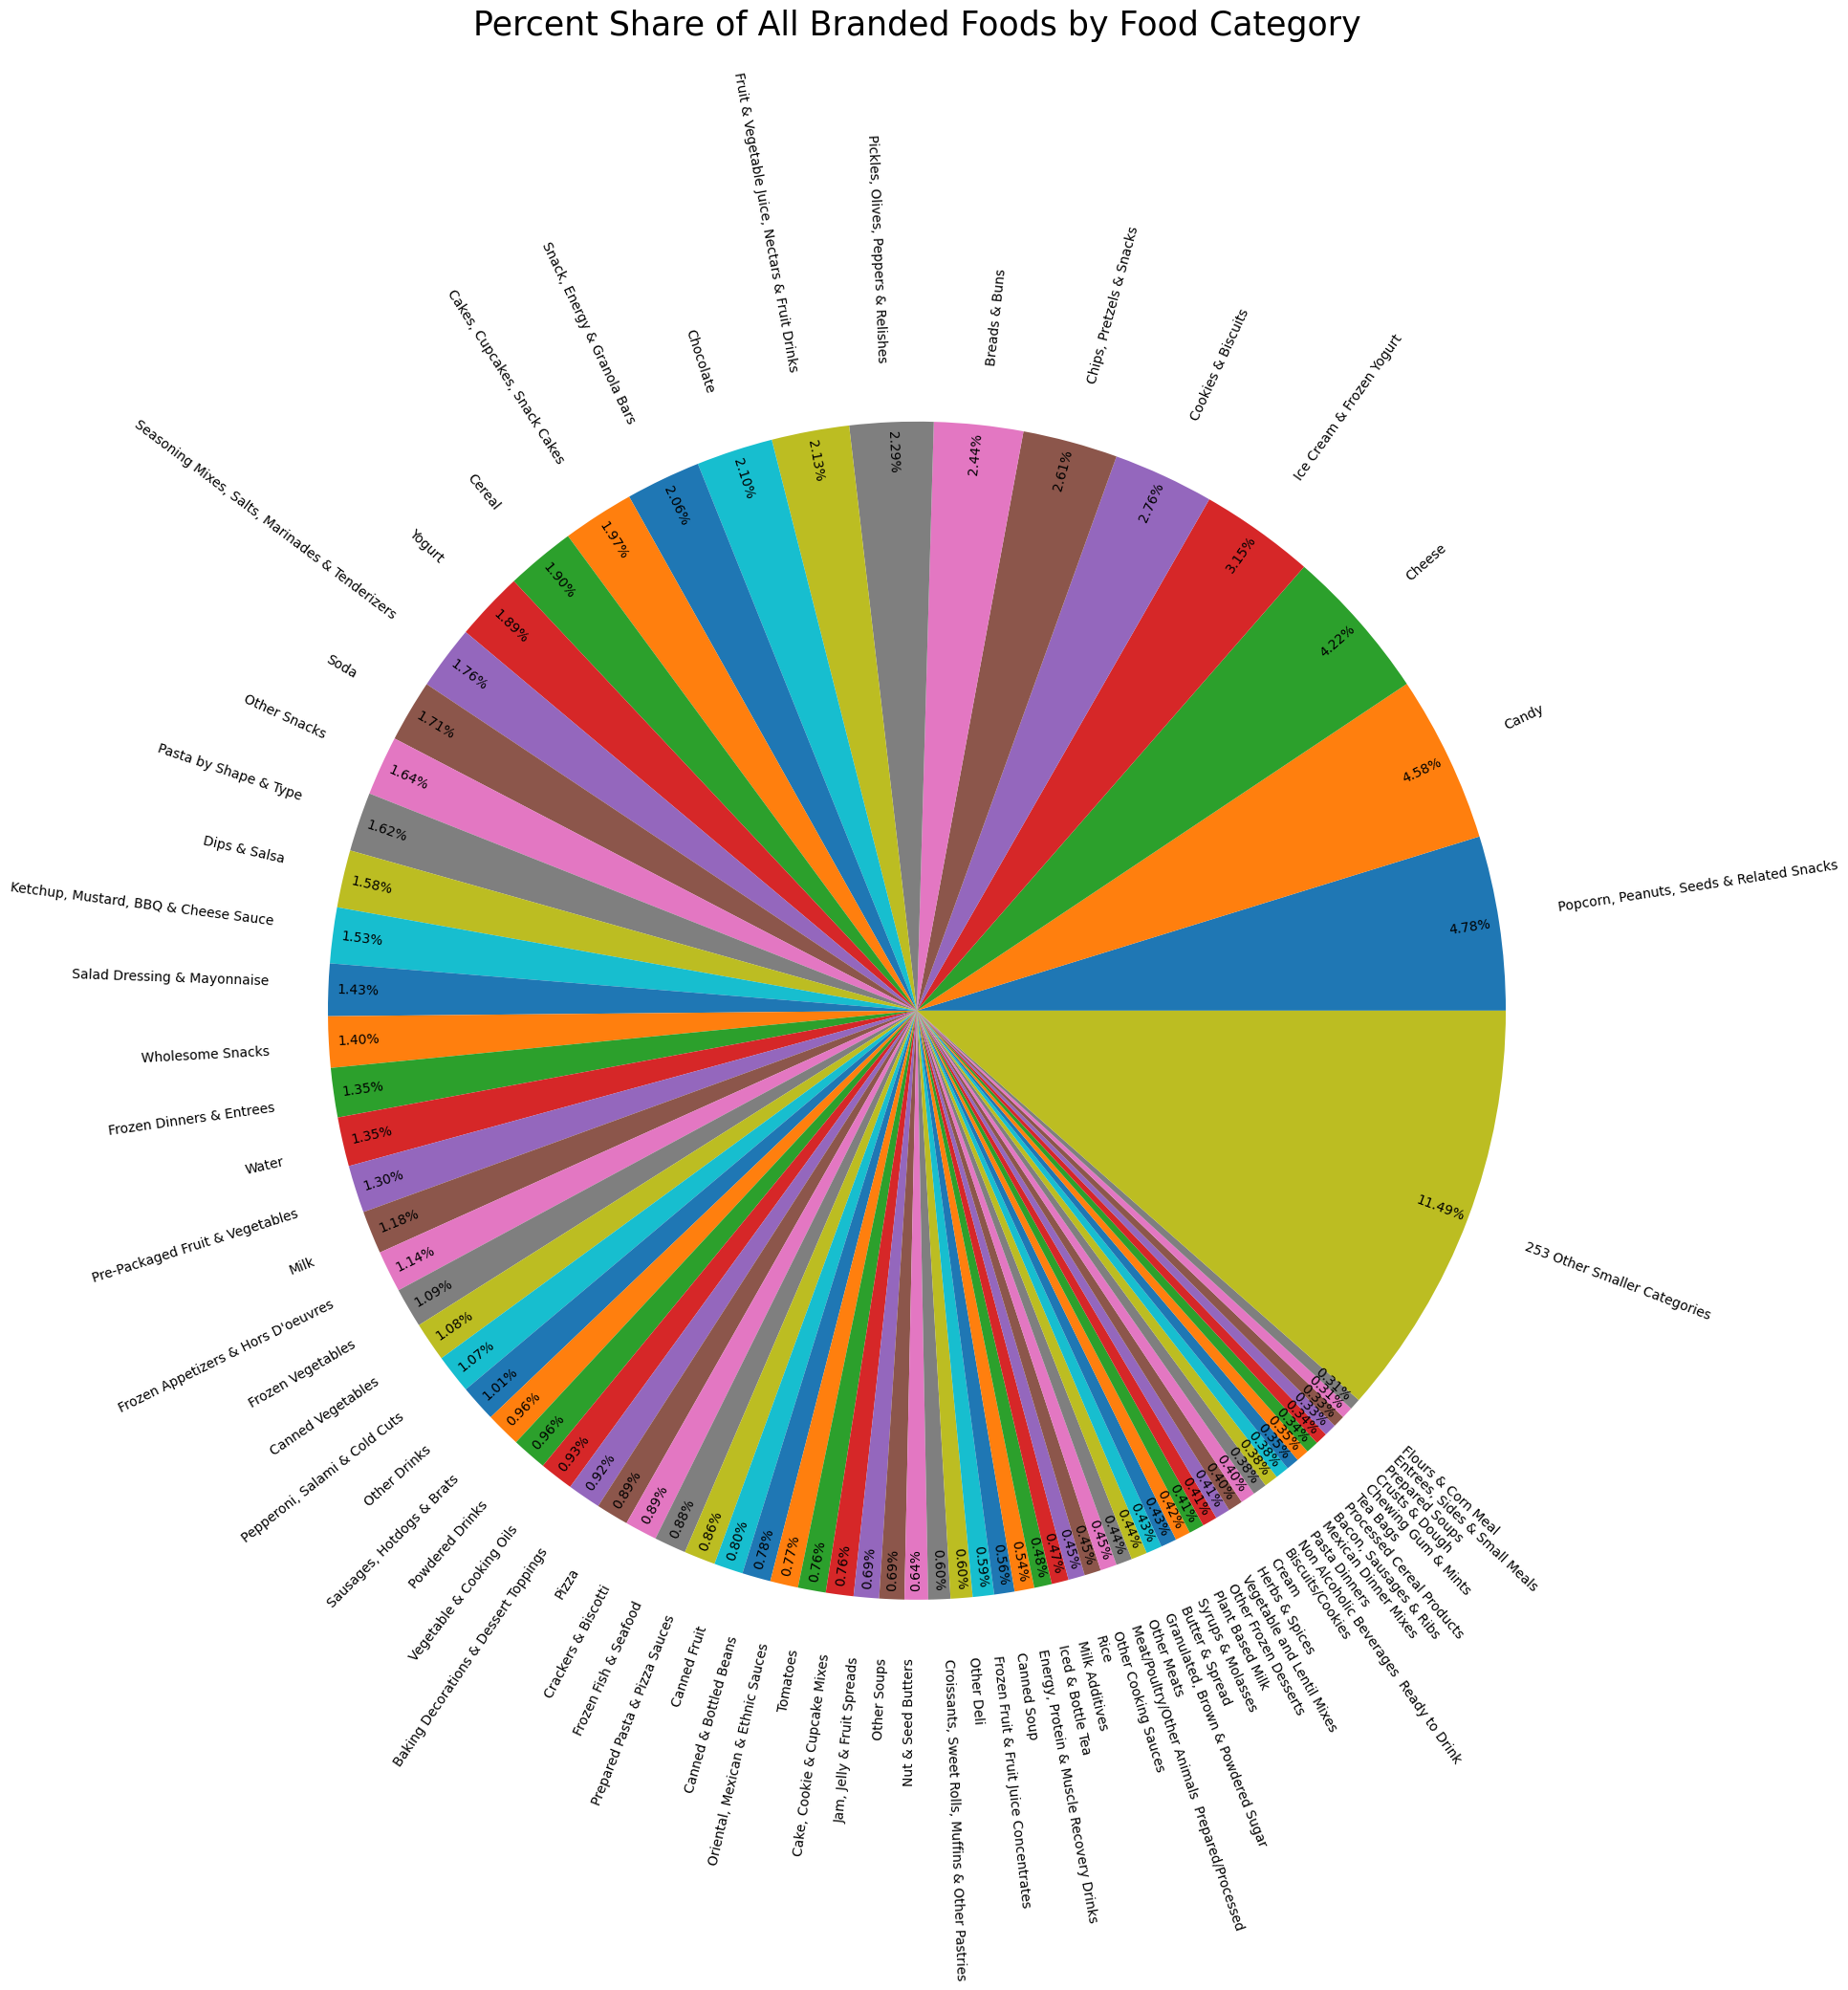

In [20]:
# creates a pie chart from the category counts of our branded food items
equal_share = known_cats['fdc_id'].count() * 1/331

cat_counts = known_cats['branded_food_category'].value_counts()
cat_counts1 = cat_counts[cat_counts >= equal_share]
cat_counts2 = cat_counts[cat_counts < equal_share]
cat_counts1[f'{cat_counts2.index.size} Other Smaller Categories'] = sum(cat_counts2.values)

plt.figure(figsize=(20, 20))
slices, texts, percentages = plt.pie(
cat_counts1.values,
labels=cat_counts1.index,
autopct='%1.2f%%',
pctdistance=0.95,
rotatelabels=True
)

# adjust rotation so the pencentage labels are pointing to the center to improve readability
for slices, percentages in zip(slices, percentages):
    # calculate the rotation angle based on bisector of the slice angles
    angle = (slices.theta2 + slices.theta1) / 2
    # flips text to match orientation of category labels
    if angle < 90 or angle > 270:
        rotation = angle
    else:
        rotation = angle - 180
    percentages.set_rotation(rotation)  # set the rotation

# set the title
plt.title('Percent Share of All Branded Foods by Food Category', pad=180, fontsize=25)

plt.show() # display the pie chart

This nicely visualizes the most dominant categories taking up our data, but due to the unavoidable truncation it's difficult to picture the overall distribution across all categories.

However we can already tell it is very skewed. In fact, the top 10 of 331 food categories are shown to make up 31.06% of our branded food data. Half of the pie falls into just 21 categories.

To better visualize the entire distribution and exactly how skewed it is, let's make a bar plot without truncation (so categories will be unlabeled).

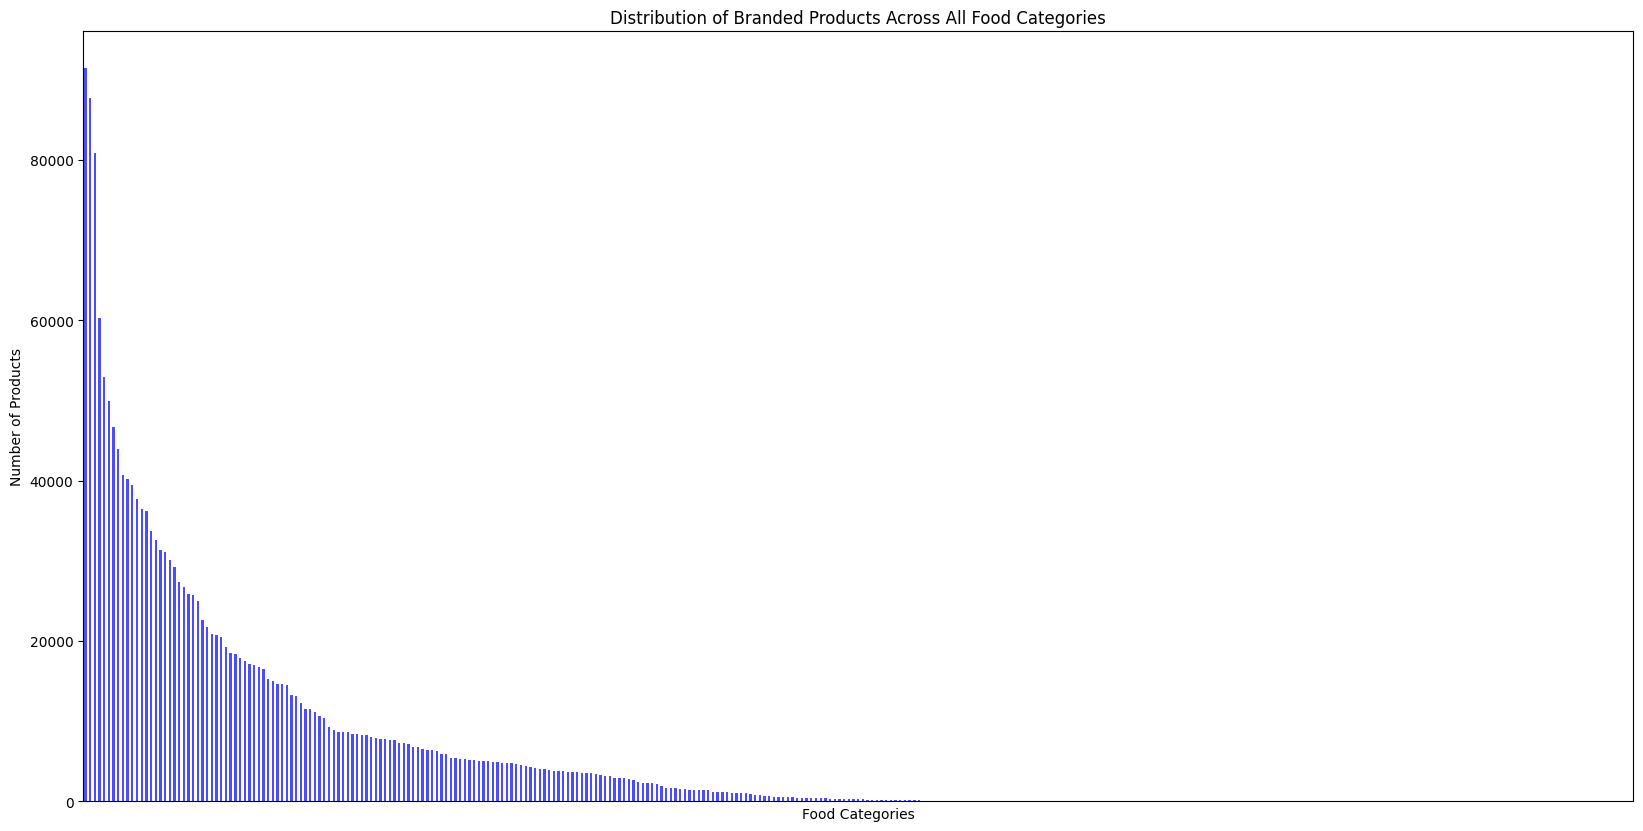

In [21]:
plt.figure(figsize=(20, 10)) 
cat_counts.plot(kind='bar', color='blue', alpha=0.7)
y = cat_counts.values

plt.xlabel('Food Categories')
plt.ylabel('Number of Products')
plt.title('Distribution of Branded Products Across All Food Categories')
plt.xticks([])  # no x-axis ticks/labels

plt.show()  # display the bar chart

Now the **extremely positive skew** is shown. It is so skewed that while we assure you that all data was plotted and bars are fit perfectly to the x-axis space, it looks like half the categories are empty.

To wrap up here are some summary stats about our food categories:

In [22]:
print('# of Categories with Less than 100 Branded Items: ', sum(known_cats['branded_food_category'].value_counts() < 100))
print('Median # of Items for Each Category (middle of distribution): ', known_cats['branded_food_category'].value_counts().median())
print('Mean # of Items for Each Category: ', known_cats['branded_food_category'].value_counts().mean())
print('Upper 10 Percent of Categories # of Items Lower Bound: ', known_cats['branded_food_category'].value_counts().quantile(0.90))
print('Lower 25 Percent of Categories # of Items Upper Bound: ', known_cats['branded_food_category'].value_counts().quantile(0.25))
print('Categories with Only One Branded Item: ', sum(known_cats['branded_food_category'].value_counts() == 1))

# of Categories with Less than 100 Branded Items:  149
Median # of Items for Each Category (middle of distribution):  264.0
Mean # of Items for Each Category:  5782.350453172206
Upper 10 Percent of Categories # of Items Lower Bound:  17871.0
Lower 25 Percent of Categories # of Items Upper Bound:  9.0
Categories with Only One Branded Item:  28


#### Conclusions
- "Popcorn, Peanuts, Seeds, & Related Snacks", "Candy", and "Cheese" are the top 3 categories of categorized branded food items.
- 88.51% of branded foods can be categorized into 78 categories (top 30.83% that have greater than or equal to the mean # of items), with the remaining, 11.49%, falling into the other 253 categories (bottom 69.17% that have less than the mean). Thus, an extremely positive skew.
- 28 food categories (8.46%) consist of a singular branded item.
  
**Takeaway for ML**: From all of this, we can see that our dataset is extremely **imbalanced** due to certain food categories having relatively a *lot* more variation in branded foods, causing an extremely positive skew in the distribution of products. Most food categories have less than a few hundred data points. A big chunk have less than 10! 

Thus for whichever machine learning algorithm we use to categorize food, we must narrow our training set a lot to ignore insignificant categories with too little data to train the model off of (like those with < 10 entries). To do this we must decide on a balance between the range of categories the model can predict and removing insignificant categories. We also need to train the model in a way such that the distribution of the data is somewhat preserved, as evidently most foods should belong in them. 

All of this is to avoid the model placing too much training importance on larger categories (making it ignore the possiblity of a food belonging in any smaller less likely categories even if one might fit better) or on smaller categories (making it completely memorize the few data points they have). This in turn prevents **overfitting**, i.e. performing well on predicting training data but badly on new inputs / new foods with unknown categories.

### 2.2. Distribution of Ingredients by Food Category <a class="anchor" id="22"></a>

Now that we have an idea of how *products* are distributed across categories, we will now take a peek into the distribution of *ingredients* in products per category. What are the most common ingredients from each individual category? To what extent do the top ingredients differ between certain categories? 

We can create a function that answers the first question for us and plots the result for any category we are interested in, which we can then use to answer the second question by comparing plots. 

Because the format of the "ingredients" listing (string) for each food item in the dataset is inconsistent, let us first create a new DataFrame "ingred_df" where ingredients strings are split by possible delimiters such that a "cleaned_ingredients" column contains lists of individual ingredients.
> Note: Due to many different subtle differences in how ingredients are formatted, our basic cleaning likely is not exhaustive. For the purposes of this initial data exploration we do not need it to be. However, in practice for our primary analysis we will definitely not be splitting up ingredients like this (such that each one is equally weighted) - instead we will convert full ingredient strings into vectors. We will touch more on this in section [3](#3).

In [27]:
# function to clean an ingredients string and transform it into a list
def clean_ingredients(ingredients_text):
    # remove start of string "INGREDIENTS: "
    ingredients_text = re.sub(r"(?i)^INGREDIENTS:\s*", "", ingredients_text)
        
    # standardize formatting
    cleaned_text = re.sub(r"\([^)]*\)", "", ingredients_text)
    
    # split by commas
    ingredients = [ingredient.strip() for ingredient in cleaned_text.split(",")]
    
    # handle special cases AND/OR and [CONTAINS LESS THAN] _ PERCENT OF
    final_ingredients = []
    for ingredient in ingredients:
        if "AND/OR" in ingredient:
            ings = ingredient.split("AND/OR")
            final_ingredients.extend([ing.strip() for ing in ings])
        if re.search(r"\d+% OF:\s*(.*)", ingredient):
            match = re.search(r"\d+% OF:\s*(.*)", ingredient)
            final_ingredients.append(match.group(1).strip())
        else:
            final_ingredients.append(ingredient.strip())
    
    # removes possible period at the end of ingredients list
    if final_ingredients and final_ingredients[-1].endswith("."):
        final_ingredients[-1] = final_ingredients[-1][:-1]

    return final_ingredients

ingred_df = brand_df
ingred_df['cleaned_ingredients'] = ingred_df['ingredients'].apply(clean_ingredients)

print('cleaned_ingredients column first 10 foods:\n', 
      ingred_df['cleaned_ingredients'].head(10))


cleaned_ingredients column first 10 foods:
 0                                      [Vegetable Oil]
1    [BEEF STOCK, MIREPOIX, SALT, NATURAL FLAVORING...
2    [CLAM STOCK, POTATOES, CLAMS, CREAM, VEGETABLE...
3    [WATER, CREAM, BROCCOLI, CELERY, VEGETABLE OIL...
4    [CHICKEN STOCK, YEAST EXTRACT, DEHYDRATED CHIC...
5    [WATER, PEA BEANS, CARROTS, COOKED HAM - WATER...
6    [BEEF STOCK, MIREPOIX, SALT, NATURAL FLAVORING...
7    [DICED TOMATOES IN TOMATO JUICE, TOMATO PUREE,...
8    [TOMATO PUREE, WATER, HIGH FRUCTOSE CORN SYRUP...
9    [WATER, TOMATO PUREE, CHICKEN AND PORK FRANKFU...
Name: cleaned_ingredients, dtype: object


We have a mostly cleaned column of ingredients accessible as lists. Now, we'll extract and count the ingredients for each entry, and put the results in a dictionary, category_ingredient_counts, that associates ingredients and their counts to each food category key.

In [ ]:
category_ingredient_counts = {}

# iterates over ingred_df row contents
for _, row in ingred_df.iterrows():
    category = row['branded_food_category']
    ingredients = row['cleaned_ingredients']
    
    # if the category is not already in the dictionary, put it in as a key and 
    # initialize corresponding counter object
    if category not in category_ingredient_counts:
        category_ingredient_counts[category] = Counter()
        
    # update the category's counter in the dict using the ingredients list - 
    # so for ['Apple, Banana, Grape, Apple'] and an empty counter it will become
    # {'Apple': 2, 'Banana': 1, 'Grape': 1} and a counter already with 
    # {Banana: 1} it will become {'Apple': 2, 'Banana': 2, 'Grape': 1}
    category_ingredient_counts[category].update(ingredients)

Within this dictionary, we now have everything that we need to visualize the distribution of ingredients across any category we'd like to look into.

Per [2.1](#2.1), we'll look into the categories that have the most variety: *Popcorn, Peanuts, Seeds & Related Snacks*, *Candy*, and *Cheese*. Let's plot the top 10 most used ingredients for each of them.

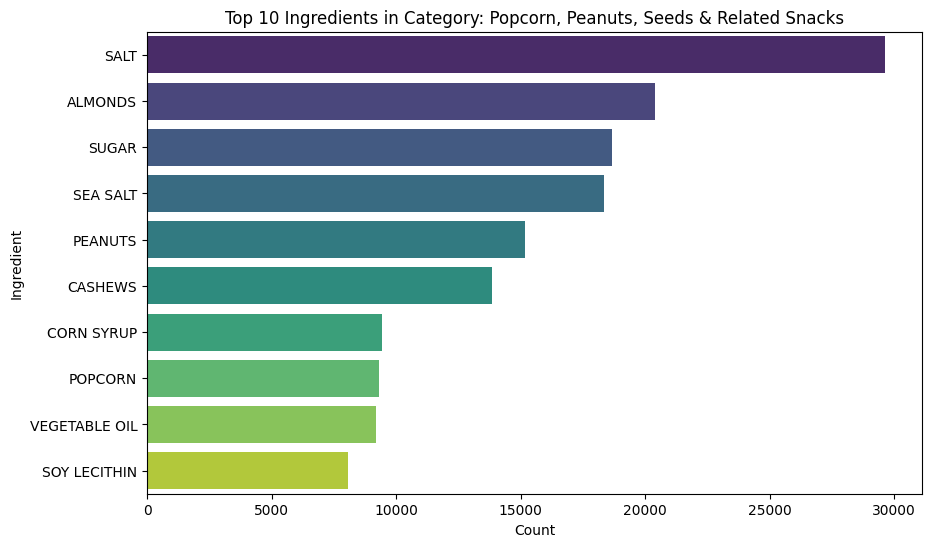

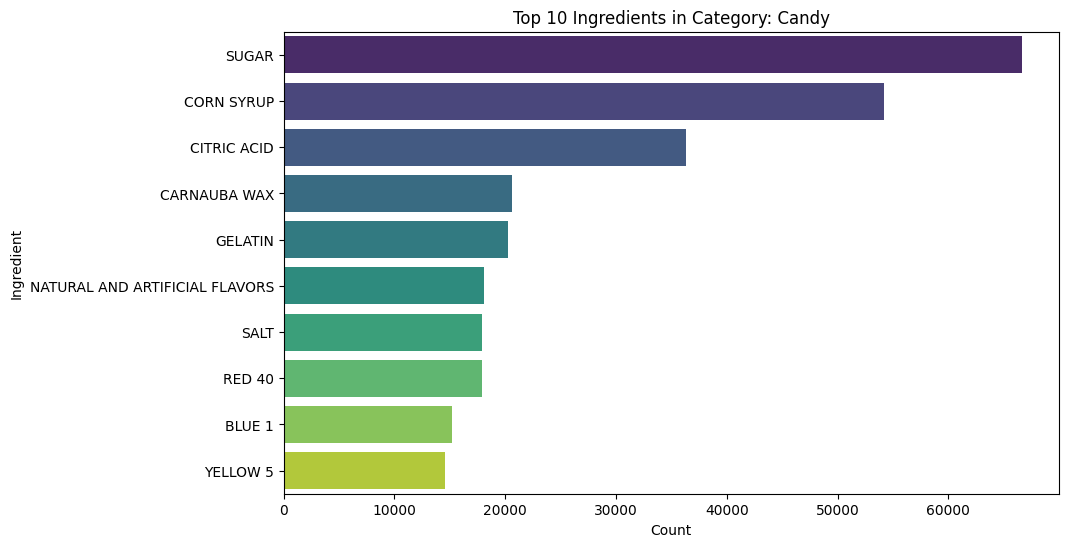

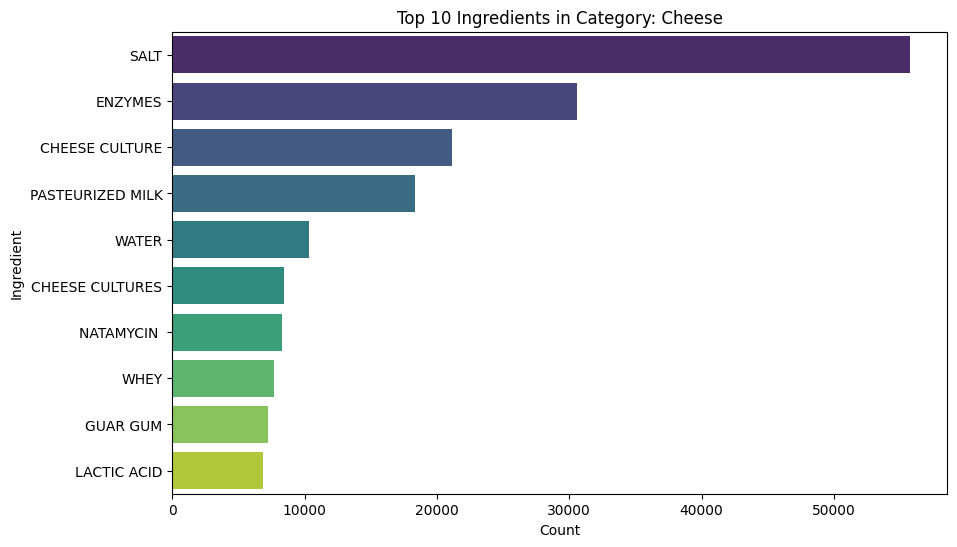

In [ ]:
# function to plot the top _ ingredient-counts from _ category
def plot_top_ingredients(category, top_n=10):
    if category not in category_ingredient_counts:
        print(f"No data for category: {category}")
        return
    
    ingredient_counts = category_ingredient_counts[category].most_common(top_n) # finds n most common ingredients
    ingredients, counts = zip(*ingredient_counts) # extracts them for plotting
    
    # creates bar chart with top n ingredients and counts
    plt.figure(figsize=(10, 6))
    sb.barplot(x=list(counts), y=list(ingredients), palette="viridis")
    plt.title(f"Top {top_n} Ingredients in Category: {category}")
    plt.xlabel("Count")
    plt.ylabel("Ingredient")
    plt.show()

# plots
plot_top_ingredients('Popcorn, Peanuts, Seeds & Related Snacks')
plot_top_ingredients('Candy')
plot_top_ingredients('Cheese')

#### Conclusions
As shown by our plots, while the top 10 ingredients in the 3 largest food categories share a few really common ones like salt and sugar, they have a lot of differences. For example, enzymes and cheese cultures are only prevalent in cheese while candy is most likely to contain artificial food dyes.

The observation that top ingredients don't widely overlap between our categories with the most variation in branded foods supports the plausibility of our primary analysis idea! It reveals that at some level it is possible to correspond foods to some categories based on the probabilities of it having certain common ingredients.

### 2.3. Simple Hypothesis Testing for Ingredient/Category Correlation <a class="anchor" id="23"></a>

Let's do a hypothesis test to further explore the association between a branded food having certain ingredients and how it's categorized!
> Note: The last section ([2.2](#2.2)) already revealed that at some general level we can match common ingredients to some categories, but this section really puts this to the test with a specific instance of how certain ingredients will effect a category placement. Is 2.2's finding true for this instance?

We picked an arbitrary category "Prepared Soups" and hypothesized that if ingredients have an effect on category, then a branded food having the words "STOCK", "BROTH", or "PUREE" in its ingredients list, based on just our common understanding of soup, would likely increase its chance of being a soup.

H0: Whether the ingredients list of a branded food has the word "STOCK", "BROTH", and/or "PUREE" does not have an effect on the likelyhood of it being in the "Prepared Soups" category.

HA: Whether the ingredients list of a branded food has the word "STOCK", "BROTH", and/or "PUREE" does have an effect on the likelyhood of it being in the "Prepared Soups" category.

alpha value = 0.05
> H0: Null Hypothesis, or statement that indicates no prescence of a relationship<br><br>HA: Alternative Hypothesis, or statement that indicates the prescence of a relationship<br><br>alpha value: Maximum value the resulting p-value from our test can be to reject the null hypothesis (with 0.05 : can have 5% maximum uncertainty, 95% minimum confidence)

We will conduct a chi-square test on a sample of the dataset. A chi-square test is appropriate for accessing the association between categorical variables, so here the association between whether a food has stock/broth/puree in its ingredients string and whether it is in "Prepared Soups."

First creating and plotting the chi-square table:

<AxesSubplot:xlabel='ingredients'>

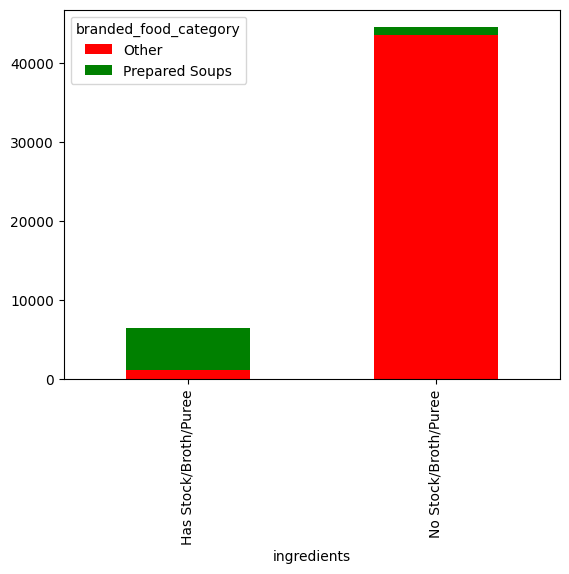

In [ ]:
known_cat = brand_df.dropna(subset=['branded_food_category']) # ignore unlabelled info

# gets a sample of the known_cat dataset with categories within sizes 5500 - 7000 
# in order to avoid inaccurate conclusion due to disproportionate category sizes
cat_counts = known_cat.groupby('branded_food_category').size()
sample_range = cat_counts[(cat_counts >= 5500) & (cat_counts <= 7000)]
sample = known_cat[known_cat['branded_food_category'].isin(sample_range.index)]

# categorizes ingredients strings in the sample into whether it contains "STOCK", "BROTH", or "PUREE"
has_stock_or_broth = sample['ingredients'].apply(
    lambda x: 'Has Stock/Broth/Puree' if re.search(r'\b(STOCK|BROTH|PUREE)\b', x, re.IGNORECASE) else 'No Stock/Broth/Puree'
)
# categorize food categories in the sample into Prepared Soups or Other
prepared_soups_other = sample['branded_food_category'].apply(
    lambda x: 'Prepared Soups' if 'Prepared Soups' in x else 'Other'
)

# creates and plots chi square table
chisqtable = pd.crosstab(has_stock_or_broth, prepared_soups_other)
chisqtable.plot.bar(stacked=True, color=['red', 'green'])

Now for the results of the test:

In [ ]:
chi2_contingency(chisqtable)

Chi2ContingencyResult(statistic=33735.96450938943, pvalue=0.0, dof=1, expected_freq=array([[ 5645.41768753,   791.58231247],
       [39099.58231247,  5482.41768753]]))

#### Conclusions
With a p-value staggeringly less than our alpha value 0.05, extremely close to 0, we are nearly 100% confident we can reject our null hypothesis. Thus, we can conclude that whether the ingredients list of a branded food has the word "STOCK", "BROTH", and/or "PUREE" does have an effect on the likelyhood of it being in the "Prepared Soups" category.

Main Takeaway: From this and our findings in [2.2](#2.2), we can agree that there is definitely a relationship between foods' ingredients and how they are categorized. Therefore it is certainly plausible for us to be able to create a ML model that predicts food categories based on ingredients. Let's do it!

## 3. Primary Analysis <a class="anchor" id="3"></a>

**Our Goal:** To create and train a machine learning model that accurately predicts what food category a branded food item belongs to based on its ingredient list.

#### Explanation of Our Method Based on Exploratory Data Analysis<a class="anchor" id="31"></a>
In section [2.1](#2.1), we found that we have a lot of categories to work with, 331. However, the distribution of products across the food categories was extremely positively skewed, specifically such that a staggering majority of our over a million branded products fell into the top third or so of categories. In addition, a lot of categories just have too little information to train a model as complex as we are trying to make (like the over 25% with less than 10 data points).

We need a machine learning model and training process that:
1. is a **classification algorithm**
    - Self explanatory: we are trying to categorize/classify data.
2. is good with **highly dimensional data** and multicollinearity
    - While we are only inputting "ingredients" strings, we will be turning the strings into vectors (more on that soon). So, the model will be working with a *lot* of very complex data with a ton of features and relationships upon relationships to parse.
3. will take into account our **skewed distribution** somewhat, and **avoids over/under fitting** like the plague
    - Without doing this, due to the imbalance our model will most certainly either overfit to smaller categories compared to larger ones by being able to memorize all of their ingredient combinations during training, or underfit to them by kind of ignoring them during training (depending on which kind of flawed implementation).

We decided that the best technique that hits all of these points is a **Random Forest** model trained using **Stratified K-Fold Cross Validation**! 

Random Forest is a classification method that does well with large complex datasets. It works by having multiple different decision trees (trees where each branch asks a question like: is the first ingredient "Sugar"?, and you follow the branches to get a prediction) that vote on the best output. Thus, hitting points 1 and 2.

K-Fold Cross Validation is a training technique for ML models in which a dataset is divided into *k* equal sized subsets ("folds"). Then the model is trained *k* times using *k-1* of those folds for training and the last one for testing, such that at the end each fold has been used once for testing. Performance results are then aggregated together at the end. By evaluating the model as its trained this way, it reduces the chance of us overfitting to a certain training set.
> And Statified K-Fold in particular ensures that the distribution of categories is similar in each fold. Thus, it takes into account our data imbalance!

#### Full Implementation Explanation<a class="anchor" id="32"></a>

1. As done in the last section we first filtered our dataset to just those with known categories. However, we also needed to reduce it since 1. our data is just way too extremely large to feed entirely into a ML model running on our own PCs, and 2. a lot of categories are just way too small to train on.
We decided to only keep category sizes that are greater than or equal to 200, which is the median rounded down to the nearest hundred of category sizes. This decision was a bit arbitrary - we just wanted to strike a bit reasonable balance between being able to predict many different categories and possible fitting issues due to including tiny categories. 
We then got our final reduced set by retrieving random samples from each category in that filtered set of either their own size or 5000, whichever is smaller. Setting the max entries to 5000 was a bit arbitrary as well, however we are just doing this to somewhat keep our skewed distribution while reducing potentially overfitting to the largest categories.

2. We then used TfidVectorizer to transform ingredients strings into vectors that will allow our model to interpret differences in ingredients more intuitively: unlike what we did in [2.2](#2.2), it doesn't just treat all ingredients with the same weight and instead also factors things like ingredient order (ingredient lists of food products tend to list the most important ingredients making up the product first), "contains less than 2% of" labels, etc.

3. We initialized StatisfiedKFold and our RandomForestClassifier

4. In order to test max_depth (max depth of decisions for trees in the random forest) and n_estimators (number of trees) inputs, we used StatisfiedKFold for accuracy predictions and adjusted as needed. We decided on the max_depth and n_estimators inputs that gave us the best accuracy values. This process had to be commented out as running our code with the following section took a really long time.

5. We did a simple training/testing set split and printed a Classification Report afterwards using our most optimal model in order to visualize accuracies for predicting different categories. 

#### Completed Model with Accuracy Report<a class="anchor" id="33"></a>

In [26]:
# step 1
threshold = 200
max_entries = 5000

filtered_df = brand_df.dropna(subset=['branded_food_category'])
filtered_df = brand_df.groupby('branded_food_category').filter(lambda x: len(x) >= threshold)

limited_df = filtered_df.groupby('branded_food_category').apply(lambda x: x.sample(min(len(x), max_entries), random_state=50)).reset_index(drop=True)

# step 2
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(limited_df['ingredients'])
y = limited_df['branded_food_category']

# step 3
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
model = RandomForestClassifier(n_estimators=32, random_state=50, n_jobs=-1, max_depth=50)

# step 4
#scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
#model.fit(X, y)
#printed scores

# step 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8791198781012952
                                                              precision    recall  f1-score   support

                                                     Alcohol       0.95      0.88      0.91       724
                                                 All Noodles       0.92      0.90      0.91       831
                                      Bacon, Sausages & Ribs       0.89      0.89      0.89      1000
                                 Baking Additives & Extracts       0.94      0.70      0.80       743
                       Baking Decorations & Dessert Toppings       0.92      0.85      0.88      1000
                               Baking/Cooking Mixes/Supplies       0.94      0.95      0.94       705
                                            Biscuits/Cookies       0.89      0.96      0.92      1000
                             Biscuits/Cookies (Shelf Stable)       0.78      0.77      0.77       209
                                                    

In [ ]:
threshold = 200
max_entries = 5000

filtered_df = brand_df.dropna(subset=['branded_food_category'])
filtered_df = brand_df.groupby('branded_food_category').filter(lambda x: len(x) >= threshold)

limited_df = filtered_df.groupby('branded_food_category').apply(lambda x: x.sample(min(len(x), max_entries), random_state=50)).reset_index(drop=True)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(limited_df['ingredients'])
y = limited_df['branded_food_category']


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
model = RandomForestClassifier(n_estimators=32, random_state=50, n_jobs=-1, max_depth=50)
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)

model.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8791198781012952
                                                              precision    recall  f1-score   support

                                                     Alcohol       0.95      0.88      0.91       724
                                                 All Noodles       0.92      0.90      0.91       831
                                      Bacon, Sausages & Ribs       0.89      0.89      0.89      1000
                                 Baking Additives & Extracts       0.94      0.70      0.80       743
                       Baking Decorations & Dessert Toppings       0.92      0.85      0.88      1000
                               Baking/Cooking Mixes/Supplies       0.94      0.95      0.94       705
                                            Biscuits/Cookies       0.89      0.96      0.92      1000
                             Biscuits/Cookies (Shelf Stable)       0.78      0.77      0.77       209
                                                    

Woohoo, we achieved 88% accuracy! Notice how some categories have really bad accuracy. However, you can see that a majority of these bad accuracy categories are really similar in name to other ones with very accurate ones (like Bread with 92% versus Bread (Frozen) with 0%) Thus, we can conclude that there are a lot of redundant categories!

## 4. Visualization <a class="anchor" id="4"></a>

We can now use this model to predict the foods with unknown categories in brand_df!

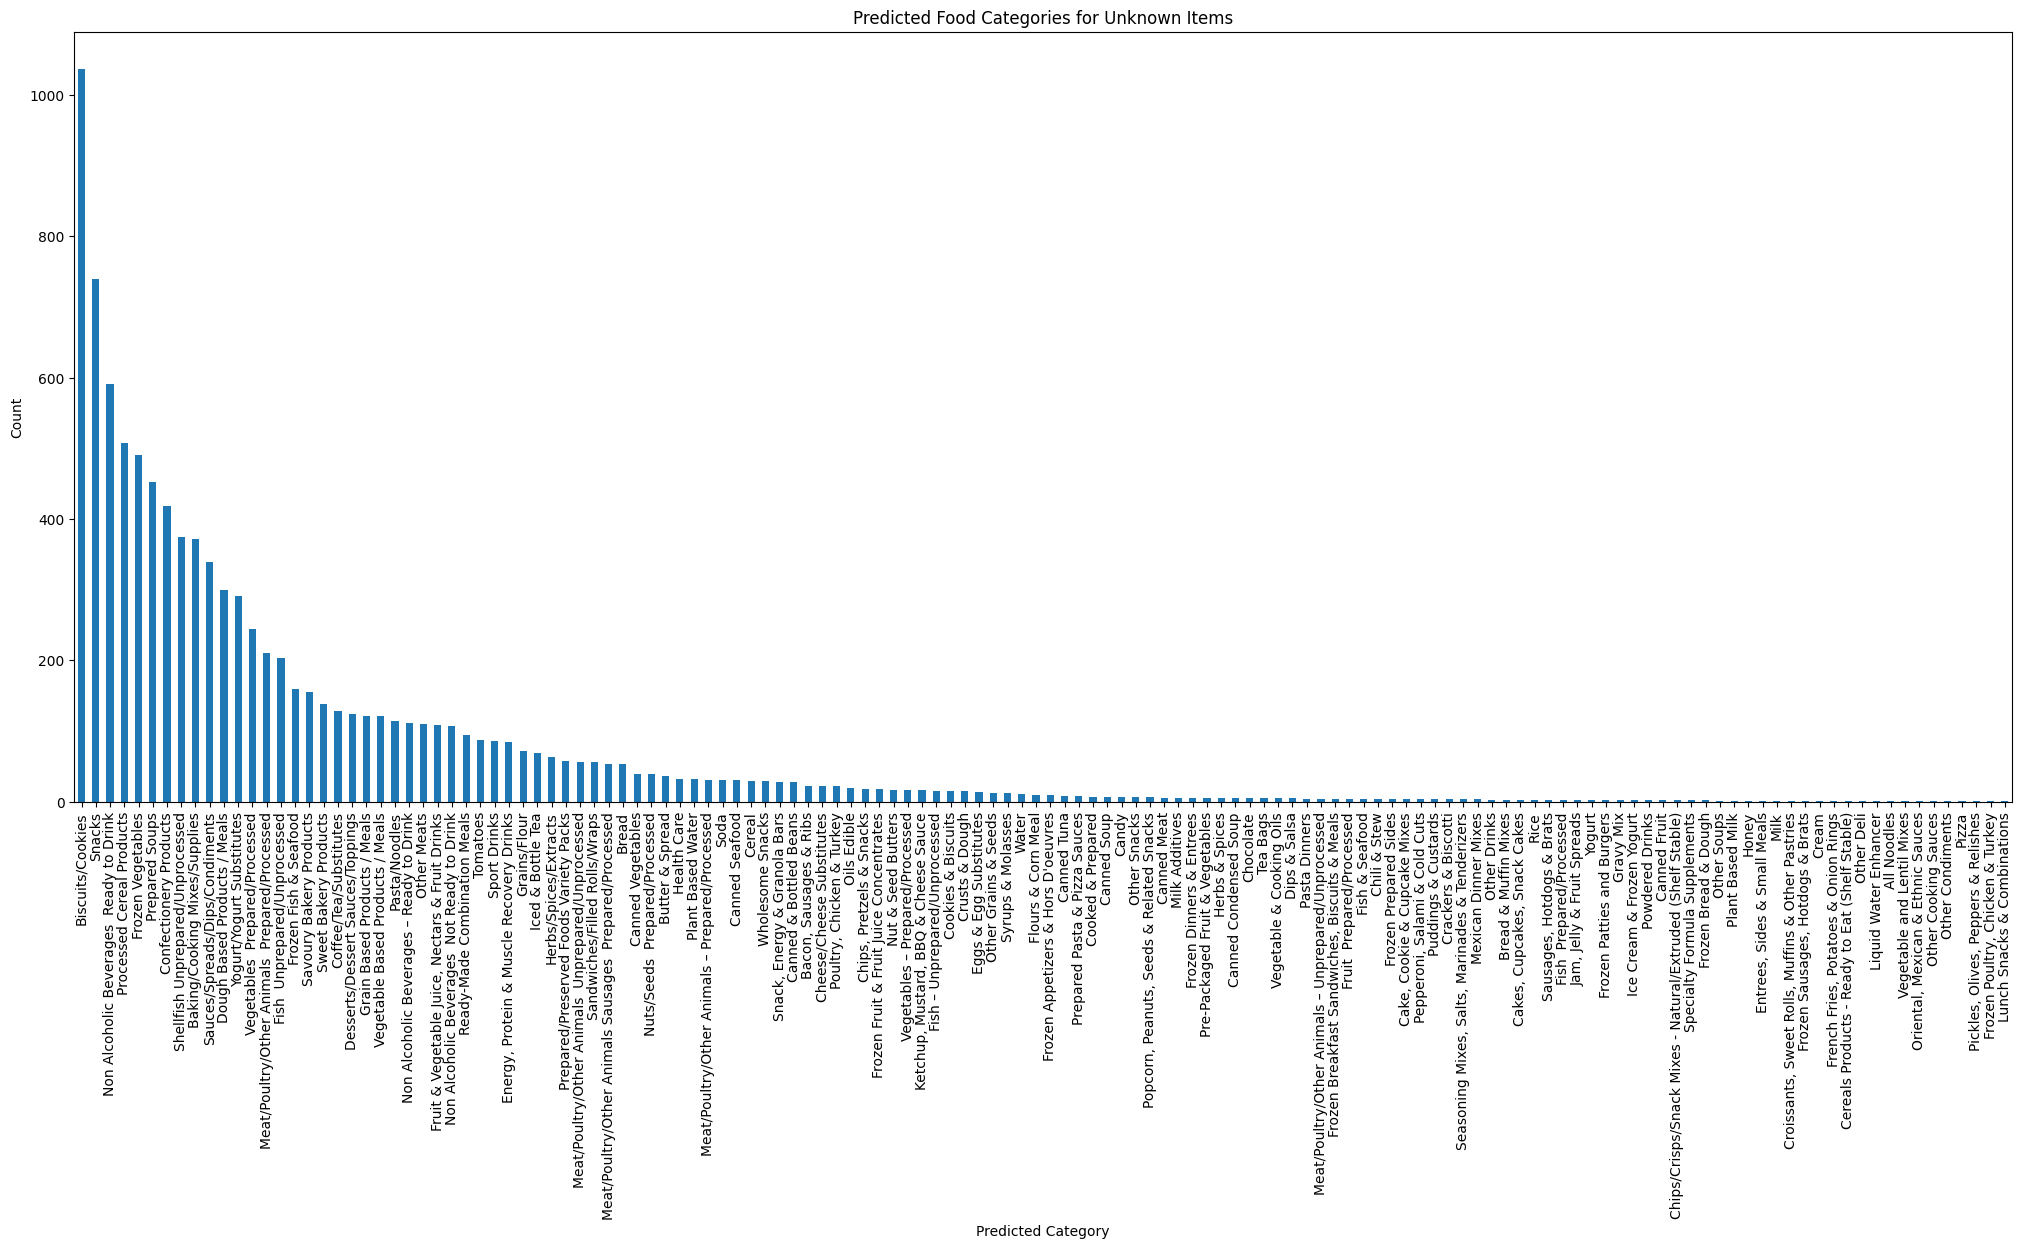

In [34]:
unknown_df = brand_df[brand_df['branded_food_category'].isnull()] # store brand_df entries with unknown categories into unknown_df

# transform unknown_df ingredients into vectors and input into our Random Forest model 
X_unknown = vectorizer.transform(unknown_df['ingredients'])
predictions = model.predict(X_unknown)

# set predictions as column in unknown_df
unknown_df['predicted_category'] = predictions

# get the distribution of predicted categories and plot
predicted_counts = unknown_df['predicted_category'].value_counts()
plt.figure(figsize=(25, 10))
predicted_counts.plot.bar()
plt.title("Predicted Food Categories for Unknown Items")
plt.xlabel("Predicted Category")
plt.ylabel("Count")

plt.show()

Conclusion: Of unknown category foods, most seem to be biscuits/cookies.

Based on the names of those predicted to be "Cereals", its seems that our predictions hit the mark.

In [38]:
print('Food Names of Those Predicted to Be Cereals:\n', unknown_df[unknown_df['predicted_category'] == 'Cereal']['name'])

Food Names of Those Predicted to Be Cereals:
 35201          PETER PAN Plus Creamy Peanut Butter, 16.3 OZ
36491     Quaker Oats Heart Healthy Old Fashioned Oats 4...
37783                                           Trix Cereal
38841                  GMILLS COOKIE CRISP SWEETENED CEREAL
38916     Quaker Steel Cut 3 Minute Blueberry Cranberry ...
38932     Quaker Select Starts Organic Instant Oatmeal O...
39144     Quaker Steel Cut 3 Minute Oats 25 Ounce Paper ...
39150     Quaker 50% Less Sugar Apple Walnut Instant Oat...
39533       Quaker Steel Cut Oats 30.0 Ounce Paper Canister
39740     Quaker Oats Old Fashioned Oatmeal 18 Ounce Pap...
39788     Quaker Oats Old Fashioned Oats 42 Ounce Paper ...
39838     Quaker Protein Cranberry Almond Instant Oatmea...
39985     Quaker Real Medleys Apple Walnut Oatmeal 2.64 ...
40283     Quaker Steel Cut 3 Minute Brown Sugar & Cinnam...
40471                MOTHER'S INSTANT OATMEAL REGULAR   11Z
40527          Quaker Oats 1 Minute Oats 42 Ounce Pape

## 5. Insights and Conclusions <a class="anchor" id="5"></a>

In conclusion, we found that a model with 88% accuracy could be made that predicts branded food categories based on ingredients.

What if USDA can use this model to help sort branded foods and remove redundant categories? 